## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from datetime import datetime
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Layer, Input, GRU, SimpleRNN
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import shap

In [2]:
# Hide warnings!
import warnings
warnings.filterwarnings("ignore")

In [3]:
# For reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Forecasting CO based on PM2.5 pre-trained model

In [4]:
# Importing dataset from station Aotizhongxin
df = pd.read_csv("datasets/cleaned_df.csv")

In [5]:
df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,6,1.2


In [6]:
# Defining features and target
features_CO = df.drop(columns = ['PM10','SO2','PM2.5','NO2','O3'])

In [7]:
features_CO

,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,300.0,-0.7,1023.0,-18.8,0.0,6,4.4
1,300.0,-1.1,1023.2,-18.2,0.0,3,4.7
2,300.0,-1.1,1023.5,-18.2,0.0,6,5.6
3,300.0,-1.4,1024.5,-19.4,0.0,7,3.1
4,300.0,-2.0,1025.2,-19.5,0.0,3,2.0
...,...,...,...,...,...,...,...
35059,400.0,12.5,1013.5,-16.2,0.0,7,2.4
35060,500.0,11.6,1013.6,-15.1,0.0,14,0.9
35061,700.0,10.8,1014.2,-13.3,0.0,7,1.1
35062,700.0,10.5,1014.4,-12.9,0.0,6,1.2


In [8]:
features_CO.isna().sum()

CO      0
TEMP    0
PRES    0
DEWP    0
RAIN    0
wd      0
WSPM    0
dtype: int64

In [9]:
# Changing the position of the 'wd' column

# Column to move
col_to_move = 'wd'

# Get a list of all columns
cols = list(features_CO.columns)

# Remove the column from the list
cols.remove(col_to_move)

# Append the column to the end of the list
cols.append(col_to_move)

# Reindex the DataFrame
features_CO = features_CO[cols]

In [10]:
features_CO

,CO,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,300.0,-0.7,1023.0,-18.8,0.0,4.4,6
1,300.0,-1.1,1023.2,-18.2,0.0,4.7,3
2,300.0,-1.1,1023.5,-18.2,0.0,5.6,6
3,300.0,-1.4,1024.5,-19.4,0.0,3.1,7
4,300.0,-2.0,1025.2,-19.5,0.0,2.0,3
...,...,...,...,...,...,...,...
35059,400.0,12.5,1013.5,-16.2,0.0,2.4,7
35060,500.0,11.6,1013.6,-15.1,0.0,0.9,14
35061,700.0,10.8,1014.2,-13.3,0.0,1.1,7
35062,700.0,10.5,1014.4,-12.9,0.0,1.2,6


In [11]:
# Create sequences
SEQ_LENGTH = 1
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0] 
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
fine_tuning_size = [0.1, 0.2, 0.3, 0.4, 0.5]

In [13]:
best_params_ann =  {'num_hidden_layers': 1, 'num_units': 8, 'dropout_rate': 0.14382634727054072, 
                  'learning_rate': 0.001540087615233534, 'regularization': None, 
                  'regularization_strength': 0}

In [14]:
def train_test_split_standardize(train_size):
    
    len_train = int(train_size * len(features_CO))
    
    train_df = features_CO.iloc[:len_train, :-1]
    test_df = features_CO.iloc[len_train:, :-1]
    
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    train_df['wd'] = features_CO.iloc[:len_train, -1]
    test_df['wd'] = features_CO.iloc[len_train:, -1]
    
    X_train, y_train = create_sequences(np.array(train_df), SEQ_LENGTH)
    X_test, y_test = create_sequences(np.array(test_df), SEQ_LENGTH)
    
    return X_train, y_train, X_test, y_test

In [15]:
X_train_CO, y_train_CO, X_test_CO, y_test_CO = train_test_split_standardize(0.3)

In [16]:
print("Train shape: ", X_train_CO.shape)
print("Test shape: ", X_test_CO.shape)

Train shape:  (10518, 1, 7)
Test shape:  (24544, 1, 7)


In [17]:
X_train_CO

array([[[-8.92289529e-01, -1.30927509e+00,  1.30236737e+00, ...,
         -6.20225909e-02,  2.44235361e+00,  6.00000000e+00]],

       [[-8.92289529e-01, -1.34717207e+00,  1.32307167e+00, ...,
         -6.20225909e-02,  2.70391712e+00,  3.00000000e+00]],

       [[-8.92289529e-01, -1.34717207e+00,  1.35412812e+00, ...,
         -6.20225909e-02,  3.48860768e+00,  6.00000000e+00]],

       ...,

       [[-6.08273174e-01, -1.13035246e-02, -1.61693932e+00, ...,
         -6.20225909e-02, -8.70784300e-01,  1.00000000e+00]],

       [[-6.08273174e-01,  1.71192105e-02, -1.59623501e+00, ...,
         -6.20225909e-02, -7.83596461e-01,  1.00000000e+00]],

       [[-6.08273174e-01,  1.21335906e-01, -1.52376996e+00, ...,
         -6.20225909e-02,  1.09409591e-03,  4.00000000e+00]]])

In [53]:
mse_scores = []
mae_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

for s in fine_tuning_size:
    
    # Training set
    
    X_train_CO, y_train_CO, X_test_CO, y_test_CO = train_test_split_standardize(s)
        
    # Loading the saved model
    pre_trained_model = tf.keras.models.load_model('pre_trained_models/LSTM_model.h5')
    pre_trained_model.compile(optimizer=Adam(learning_rate = best_params_ann['learning_rate']/10), loss='mse', metrics=['mae'])
    pre_trained_model.fit(X_train_CO, y_train_CO, epochs = 50, batch_size=32, shuffle=False)
    
    # Make predictions on the test data
    y_pred_ft = pre_trained_model.predict(X_test_CO)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_CO, y_pred_ft)
    mae = mean_absolute_error(y_test_CO, y_pred_ft)
    r2 = r2_score(y_test_CO, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_CO, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_CO, y_pred_ft))
    
    # Append to list scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    

Epoch 1/50
110/110 [==============================] - 1s 2ms/step - loss: 0.1350 - mae: 0.2292
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1353 - mae: 0.2255
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1289 - mae: 0.2230
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1274 - mae: 0.2212
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1252 - mae: 0.2196
Epoch 6/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1255 - mae: 0.2204
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1317 - mae: 0.2244
Epoch 8/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2257
Epoch 9/50
110/110 [==============================] - 0s 2ms/step - loss: 0.1280 - mae: 0.2234
Epoch 10/50
110/110 [==============================] - 0s 1ms/step - loss: 0.1280 - mae: 0.2235
Epoch 11/50
110/110 [============================

220/220 [==============================] - 0s 2ms/step - loss: 0.1276 - mae: 0.2145
Epoch 36/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1302 - mae: 0.2156
Epoch 37/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1287 - mae: 0.2160
Epoch 38/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1214 - mae: 0.2114
Epoch 39/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1238 - mae: 0.2128
Epoch 40/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1247 - mae: 0.2131
Epoch 41/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1276 - mae: 0.2122
Epoch 42/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1253 - mae: 0.2097
Epoch 43/50
220/220 [==============================] - 0s 2ms/step - loss: 0.1221 - mae: 0.2133
Epoch 44/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1273 - mae: 0.2131
Epoch 45/50
220/220 [==============================]

439/439 [==============================] - 1s 1ms/step - loss: 0.1175 - mae: 0.2031
Epoch 20/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1183 - mae: 0.2039
Epoch 21/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1171 - mae: 0.2030
Epoch 22/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1190 - mae: 0.2043
Epoch 23/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1164 - mae: 0.2040
Epoch 24/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1205 - mae: 0.2043
Epoch 25/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1201 - mae: 0.2041
Epoch 26/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1138 - mae: 0.2035
Epoch 27/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1231 - mae: 0.2055
Epoch 28/50
439/439 [==============================] - 1s 2ms/step - loss: 0.1184 - mae: 0.2051
Epoch 29/50
439/439 [==============================]

In [59]:
mae_scores 

[0.2555944376888157,
 0.2214324200914883,
 0.18320515372131538,
 0.2084176862892785,
 0.191470180089444]

In [60]:
mse_scores

[0.24984518962759072,
 0.1902395570319238,
 0.13308392651857767,
 0.18015100334586595,
 0.15498467048868503]

In [61]:
rmse_scores

[0.499845165653916,
 0.43616459855417405,
 0.36480669746946487,
 0.4244419905544996,
 0.39368092472036925]

In [62]:
mape_scores 

[0.624753844957274,
 2.764871418190421,
 0.501872123749755,
 0.5681707135022626,
 0.5388635120539462]

In [63]:
r2_scores

[0.9098362392321331,
 0.9140162943685546,
 0.9139519318062186,
 0.912574203013474,
 0.9131472768632045]

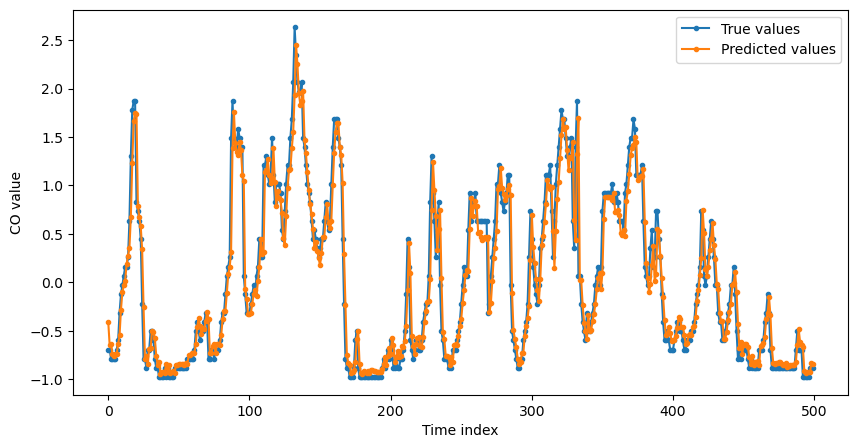

In [24]:
# Forecasting test set values

fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(np.array(y_test_CO)[:500], marker = '.', label = 'True values')
plt.plot(y_pred_ft[:500], marker = '.', label = 'Predicted values')

plt.legend()

plt.xlabel("Time index")
plt.ylabel("CO value")

#plt.savefig("actual_vs_forecasts_plot_CO.pdf")
plt.show()

## Forecasting CO without Transfer Learning

In [25]:
def build_ann_model(input_shape):
    
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(8, activation='relu'))
              
    model.add(Dropout(best_params_ann['dropout_rate']))
        
    model.add(Dense(1, activation='linear'))
                  
    model.compile(optimizer=Adam(learning_rate=best_params_ann['learning_rate']), loss='mse', metrics=['mae'])
    
    return model

In [26]:
mse_scores_2 = []
mae_scores_2 = []
rmse_scores_2 = []
mape_scores_2 = []
r2_scores_2 = []

for s in fine_tuning_size:
    # Training set
    X_train_CO, y_train_CO, X_test_CO, y_test_CO = train_test_split_standardize(s)
    
    # Loading the saved model
    model = build_ann_model(X_train_CO.shape[1:])
    model.fit(X_train_CO, y_train_CO, epochs = 50, shuffle = False, batch_size = 32)
    
    # Make predictions on the test data
    y_pred_ft = model.predict(X_test_CO)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test_CO, y_pred_ft)
    mae = mean_absolute_error(y_test_CO, y_pred_ft)
    r2 = r2_score(y_test_CO, y_pred_ft)
    mape = mean_absolute_percentage_error(y_test_CO, y_pred_ft)
    rmse = np.sqrt(mean_squared_error(y_test_CO, y_pred_ft))
    
    # Append to list scores
    mse_scores_2.append(mse)
    mae_scores_2.append(mae)
    r2_scores_2.append(r2)
    rmse_scores_2.append(rmse)
    mape_scores_2.append(mape)
    
    

Epoch 1/50
110/110 [==============================] - 1s 1ms/step - loss: 8.3241 - mae: 2.1298
Epoch 2/50
110/110 [==============================] - 0s 908us/step - loss: 2.8636 - mae: 1.1779
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 2.1720 - mae: 1.0560
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 1.7424 - mae: 0.9675
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 1.4663 - mae: 0.9009
Epoch 6/50
110/110 [==============================] - 0s 1ms/step - loss: 1.2102 - mae: 0.8284
Epoch 7/50
110/110 [==============================] - 0s 1ms/step - loss: 1.0477 - mae: 0.7798
Epoch 8/50
110/110 [==============================] - 0s 1ms/step - loss: 0.8853 - mae: 0.7269
Epoch 9/50
110/110 [==============================] - 0s 912us/step - loss: 0.6881 - mae: 0.6467
Epoch 10/50
110/110 [==============================] - 0s 1ms/step - loss: 0.5613 - mae: 0.5868
Epoch 11/50
110/110 [========================

220/220 [==============================] - 0s 1ms/step - loss: 0.1408 - mae: 0.2315
Epoch 36/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1360 - mae: 0.2300
Epoch 37/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1402 - mae: 0.2309
Epoch 38/50
220/220 [==============================] - 0s 988us/step - loss: 0.1285 - mae: 0.2249
Epoch 39/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1323 - mae: 0.2269
Epoch 40/50
220/220 [==============================] - 0s 979us/step - loss: 0.1313 - mae: 0.2269
Epoch 41/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1251 - mae: 0.2232
Epoch 42/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1415 - mae: 0.2299
Epoch 43/50
220/220 [==============================] - 0s 1ms/step - loss: 0.1358 - mae: 0.2244
Epoch 44/50
220/220 [==============================] - 0s 933us/step - loss: 0.1213 - mae: 0.2209
Epoch 45/50
220/220 [=========================

439/439 [==============================] - 0s 1ms/step - loss: 0.1359 - mae: 0.2197
Epoch 20/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1354 - mae: 0.2212
Epoch 21/50
439/439 [==============================] - 1s 1ms/step - loss: 0.1287 - mae: 0.2207
Epoch 22/50
439/439 [==============================] - 0s 921us/step - loss: 0.1293 - mae: 0.2197
Epoch 23/50
439/439 [==============================] - 0s 1ms/step - loss: 0.1297 - mae: 0.2193
Epoch 24/50
439/439 [==============================] - 0s 947us/step - loss: 0.1327 - mae: 0.2207
Epoch 25/50
439/439 [==============================] - 0s 1ms/step - loss: 0.1332 - mae: 0.2208
Epoch 26/50
439/439 [==============================] - 0s 972us/step - loss: 0.1244 - mae: 0.2170
Epoch 27/50
439/439 [==============================] - 0s 1ms/step - loss: 0.1320 - mae: 0.2206
Epoch 28/50
439/439 [==============================] - 0s 1ms/step - loss: 0.1313 - mae: 0.2197
Epoch 29/50
439/439 [=========================

In [27]:
mae_scores_2

[0.31560516459998317,
 0.2685411380548541,
 0.18450481973613372,
 0.214813160829344,
 0.20772309361260868]

In [28]:
mse_scores_2

[0.2941738594359459,
 0.20880428522231825,
 0.13373689306256265,
 0.1827962368531873,
 0.1631131512254371]

In [29]:
rmse_scores_2

[0.5423779673216326,
 0.4569510753049152,
 0.36570055108320887,
 0.42754676569141215,
 0.40387269185405084]

In [30]:
r2_scores_2

[0.8938389747432076,
 0.905625483599463,
 0.913529743258173,
 0.9112904929963334,
 0.9085921122477244]